# Spatial Resolution on Planetary Targets

L.N. Fletcher (2021)

Notebook to evaluate the diffraction-limited spatial resolution on planetary objects, using SPICE kernels and spiceypy to evaluate the distances at a specific moment in time.

[0.03145538 0.06291077 0.09436615 0.12582153 0.15727691 0.1887323
 0.22018768 0.25164306 0.28309845 0.31455383 0.34600921 0.3774646
 0.40891998 0.44037536 0.47183074 0.50328613 0.53474151 0.56619689
 0.59765228 0.62910766 0.66056304 0.69201842 0.72347381 0.75492919]  arcsec


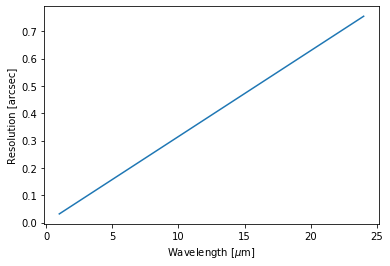

In [40]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import spiceypy as spice
import glob, re, os


# Calculate the diffraction-limited spatial resolution

diam=8.0 # Mirror diameter
wave=np.arange(1,25,1.) # Wavelength in microns
deg2rad=np.pi/180.
rad2deg=180./np.pi

ang=1.22*wave*1e-6/diam
#print(ang*rad2deg,' degrees')
arcsec=ang*rad2deg*60.*60.
print(ang*rad2deg*60.*60.,' arcsec')

fig, ax = plt.subplots()
ax.plot(wave,arcsec)
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Resolution [arcsec]")
plt.show()

### Kernel path
This is the path to the generic_kernels folder provided by NAIF (see description [here](https://naif.jpl.nasa.gov/naif/data_generic.html)). You can dowload this data to any folder by running the following command in a UNIX shell:

```bash
wget -m -nH --cut-dirs=2 -nv ftp://naif.jpl.nasa.gov/pub/naif/generic_kernels/
```
This will create the `generic_kernels` folder in the current directory, which is the location that `kernel_path` should point to.

In [41]:

kernel_path = '/Users/lnf2/Data/generic_kernels/'

def find_spice_kernels(kernel_path):
    pcks  = sorted(glob.glob(kernel_path+"pck/*.tpc"))
    spks1 = sorted(glob.glob(kernel_path+"spk/planets/*.bsp"))
    #spks1 = sorted(glob.glob(kernel_path+"spk/de*.bsp"))
    spks2 = sorted(glob.glob(kernel_path+"spk/satellites/*.bsp"))
    fks   = sorted(glob.glob(kernel_path+"fk/planets/*.tf"))
    lsks  = sorted(glob.glob(kernel_path+"lsk/naif*.tls"))


    kernels = [pcks[-1], spks1[-1], *spks2, lsks[-1]]
    #kernels = [*pcks, *spks1, *spks2, *lsks, *fks]
    
    for kernel in kernels:
        print(kernel)
        spice.furnsh(kernel)

find_spice_kernels(kernel_path)

/Users/lnf2/Data/generic_kernels/pck/pck00010.tpc
/Users/lnf2/Data/generic_kernels/spk/planets/de441_part-2.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/jup310.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/jup343.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/mar097.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/nep086.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/nep095.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/plu055.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat319.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat368.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393-rocks_pan.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat393_daphnis.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat427.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/sat428.bsp
/Users/lnf2/Data/generic_kernels/spk/satellites/ura111.bsp
/Users/lnf2/Data/generic_kernels/spk/satelli

In [46]:
utc = ['Oct 1, 2021']
et = spice.str2et(utc)
planets=['JUPITER','EUROPA','GANYMEDE','TRITON','TITANIA']
abcorr='NONE'
rad2deg=180./np.pi

#help(spice.bodvar)


for planet in planets:
    Ls=rad2deg*spice.lspcn(planet,et,abcorr)
    if Ls<90: 
        txt="(N. Spring)"
    if (Ls>=90) & (Ls<180): 
        txt="(N. Summer)"
    if (Ls>=180) & (Ls<270): 
        txt="(N. Autumn)"
    if (Ls>=270) & (Ls<360): 
        txt="(N. Winter)"
        
    [pos, ltime] = spice.spkpos( 'SUN', et, 'J2000','NONE', planet)
    dist = spice.vnorm( pos )
    dist_sun = spice.convrt( dist, 'KM', 'AU' )
    [pos, ltime] = spice.spkpos( 'EARTH', et, 'J2000','NONE', planet)
    dist = spice.vnorm( pos )
    dist_earth = spice.convrt( dist, 'KM', 'AU' )
    print(' ')
    print('{:8s}'.format(planet))
    print(utc,' (L_s): {:8.2f}'.format(Ls),txt,' Sun (AU): {:6.2f}'.format(dist_sun),' Earth (AU): {:6.2f}'.format(dist_earth))
    
    
    dim=3
    id=spice.bods2c(planet)
    rad=spice.bodvar(id,'RADII',dim)
    onedeg=2*np.pi*rad[0]/360.
    angsize=2.*rad2deg*np.arctan(rad[0]/dist)*60.*60.
    
    print('Radius: ',rad[0],' Ang. Size','{:6.3f}'.format(angsize),' Eq. Deg [km]','{:6.3f}'.format(onedeg))
    res=dist*np.tan(ang/2.)
    #res=2*dist*np.tan(ang/2.) - this is what's been reported in previous works.
    
    acrossdisc = angsize/arcsec
    print('Wavelength - Resolution (Arcsec) - Resolution (km) - AngSize/Res - Deg. at Eq.')
    for i in range(len(wave)):
        print('{:6.2f}'.format(wave[i]),'{:6.3f}'.format(arcsec[i]),'{:7.2f}'.format(res[i]),
             '{:7.2f}'.format(acrossdisc[i]),'{:7.2f}'.format(res[i]/onedeg))

 
JUPITER 
['Oct 1, 2021']  (L_s):    13.45 (N. Spring)  Sun (AU):   5.01  Earth (AU):   4.26
Radius:  71492.0  Ang. Size 46.298  Eq. Deg [km] 1247.771
Wavelength - Resolution (Arcsec) - Resolution (km) - AngSize/Res - Deg. at Eq.
  1.00  0.031   48.57 1471.86    0.04
  2.00  0.063   97.15  735.93    0.08
  3.00  0.094  145.72  490.62    0.12
  4.00  0.126  194.29  367.96    0.16
  5.00  0.157  242.86  294.37    0.19
  6.00  0.189  291.44  245.31    0.23
  7.00  0.220  340.01  210.27    0.27
  8.00  0.252  388.58  183.98    0.31
  9.00  0.283  437.15  163.54    0.35
 10.00  0.315  485.73  147.19    0.39
 11.00  0.346  534.30  133.81    0.43
 12.00  0.377  582.87  122.65    0.47
 13.00  0.409  631.44  113.22    0.51
 14.00  0.440  680.02  105.13    0.54
 15.00  0.472  728.59   98.12    0.58
 16.00  0.503  777.16   91.99    0.62
 17.00  0.535  825.74   86.58    0.66
 18.00  0.566  874.31   81.77    0.70
 19.00  0.598  922.88   77.47    0.74
 20.00  0.629  971.45   73.59    0.78
 21.00  0